<a href="https://colab.research.google.com/github/shirsh008/reinforcement-learning-model-training/blob/main/multiple_vrp_rl_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from gymnasium import spaces
from gymnasium.envs.registration import register
from enum import Enum

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class CustomEnvironment(gym.Env):
  def __init__(self, num_customers = 5, vehicle_capacity = 10, max_vehicle_count = 3):
    self.num_nodes = num_customers + 1
    self.vehicle_capacity = vehicle_capacity
    self.max_vehicle_count = max_vehicle_count
    self.action_space = spaces.Discrete(self.num_nodes)
    obs_size = 2*self.num_nodes + 3
    self.observation_space = spaces.Box(low=0, high=np.inf, shape=(obs_size,), dtype=np.float32)
    self.reset()

  def reset(self, seed = None, options= None):
    super().reset(seed=seed)
    self.locations = np.random.rand(self.num_nodes, 2)*100
    self.demands = np.random.randint(1,6, size = self.num_nodes)
    self.demands[0] = 0
    self.current_node = 0
    self.current_load = self.vehicle_capacity
    self.visited = [False] * self.num_nodes
    self.visited[0] = True
    self.nodes_visited = 0
    self.vehicle_used = 0
    return self._get_state(),{}

  def _get_state(self):
    state = [self.current_node, self.current_load, self.vehicle_used] + self.visited + self.demands.tolist()
    return np.array(state, dtype=np.float32)

  def calculate_distance(self, node_a, node_b):
    pos_a_x = self.locations[node_a][0]
    pos_a_y = self.locations[node_a][1]
    pos_b_x = self.locations[node_b][0]
    pos_b_y = self.locations[node_b][1]
    return abs(pos_a_x - pos_b_x) + abs(pos_a_y - pos_b_y)

  def step(self, action_node):
    info = {'vehicle_id': self.vehicle_used}
    if self.vehicle_used >= self.max_vehicle_count:
      reward = -100
      return self._get_state(), reward, True, False, info
    if self.visited[action_node] or self.current_load < self.demands[action_node]:
      reward = -100
      self.vehicle_used += 1
      self.current_node = 0
      self.current_load = self.vehicle_capacity
      terminated = (self.vehicle_used >= self.max_vehicle_count)
      return self._get_state(), reward, terminated, False, info

    distance = self.calculate_distance(self.current_node, action_node)

    self.current_node = action_node
    self.current_load -= self.demands[action_node]
    self.visited[action_node] = True
    self.nodes_visited += 1

    reward = -distance + 150
    reward += (self.demands[action_node] * 2)

    if self.nodes_visited == self.num_nodes-1:
      reward += 50
      terminated = True
    else:
      terminated = False

    truncated = False

    return self._get_state(), reward, terminated, truncated, info

In [4]:
env = CustomEnvironment(num_customers = 16, vehicle_capacity = 15, max_vehicle_count = 4)

In [5]:
class Policy(nn.Module):
  def __init__(self, num_nodes, h_size = 64, vehicle_capacity=15):
    super(Policy, self).__init__()
    s_size = num_nodes + 3 + num_nodes
    a_size = num_nodes
    self.fc1 = nn.Linear(s_size, h_size)
    self.fc2 = nn.Linear(h_size, a_size)
    self.num_nodes = num_nodes
    self.vehicle_capacity = vehicle_capacity

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

  def act(self, state):
    state_tensor = preprocess_state(state, self.num_nodes, self.vehicle_capacity)
    logits = self.forward(state_tensor).cpu()
    m = Categorical(logits=logits)
    action = m.sample()
    return action.item(), m.log_prob(action)

In [6]:
def preprocess_state(state, num_nodes, max_capacity):
    state_tensor = torch.from_numpy(state).float()

    state_tensor[1] /= max_capacity
    state_tensor[3 + num_nodes:] /= max_capacity

    state_tensor = state_tensor.unsqueeze(0)

    return state_tensor.to(device)

In [7]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
  scores = [[] for _ in range(env.max_vehicle_count)]
  for i_episodes in range(1, n_training_episodes+1):
    saved_log_probs = [[] for _ in range(env.max_vehicle_count)]
    rewards = [[] for _ in range(env.max_vehicle_count)]
    state, _ = env.reset()
    for t in range(max_t):
      action, log_prob = policy.act(state)
      state, reward, terminated, truncated, info = env.step(action)
      vehicle_id = info['vehicle_id']
      saved_log_probs[vehicle_id].append(log_prob)
      rewards[vehicle_id].append(reward)
      if terminated or truncated:
        break
    for i in range(env.max_vehicle_count):
      scores[i].append(sum(rewards[i]))

    policy_loss = []

    for t in range(env.max_vehicle_count):
      vehicle_rewards= rewards[t]
      vehicle_log_prob = saved_log_probs[t]

      R = 0
      returns = []
      for r in reversed(vehicle_rewards):
        R = r + gamma * R
        returns.insert(0, R)

      if len(returns) > 0:
        returns = torch.tensor(returns, dtype=torch.float32)
        if returns.shape[0] > 1:
          eps = np.finfo(np.float32).eps.item()
          returns = (returns - returns.mean()) / (returns.std() + eps)

        for log_prob, disc_return in zip(vehicle_log_prob, returns):
          policy_loss.append(-log_prob * disc_return)
    if len(policy_loss) > 0:
      optimizer.zero_grad()
      policy_loss = torch.cat(policy_loss).sum()
      policy_loss.backward()
      optimizer.step()
  return scores

In [8]:
s_size = 2*env.num_nodes + 1
a_size = env.num_nodes
vrp_hyperparameters = {
    "h_size" : 64,
    "n_training_episodes" : 5000,
    "n_evaluation_episodes" : 10,
    "max_t" : 20,
    "gamma" : 1.0,
    "lr" : 1e-2,
    "state_space" : s_size,
    "action_space" : a_size,
}

In [9]:
vrp_policy = Policy(env.num_nodes, h_size = vrp_hyperparameters["h_size"], vehicle_capacity=env.vehicle_capacity).to(device)
vrp_optimizer = optim.Adam(vrp_policy.parameters(), lr = vrp_hyperparameters["lr"])

In [10]:
scores = reinforce(vrp_policy,
                   vrp_optimizer,
                   vrp_hyperparameters["n_training_episodes"],
                   vrp_hyperparameters["max_t"],
                   vrp_hyperparameters["gamma"],
                   100)

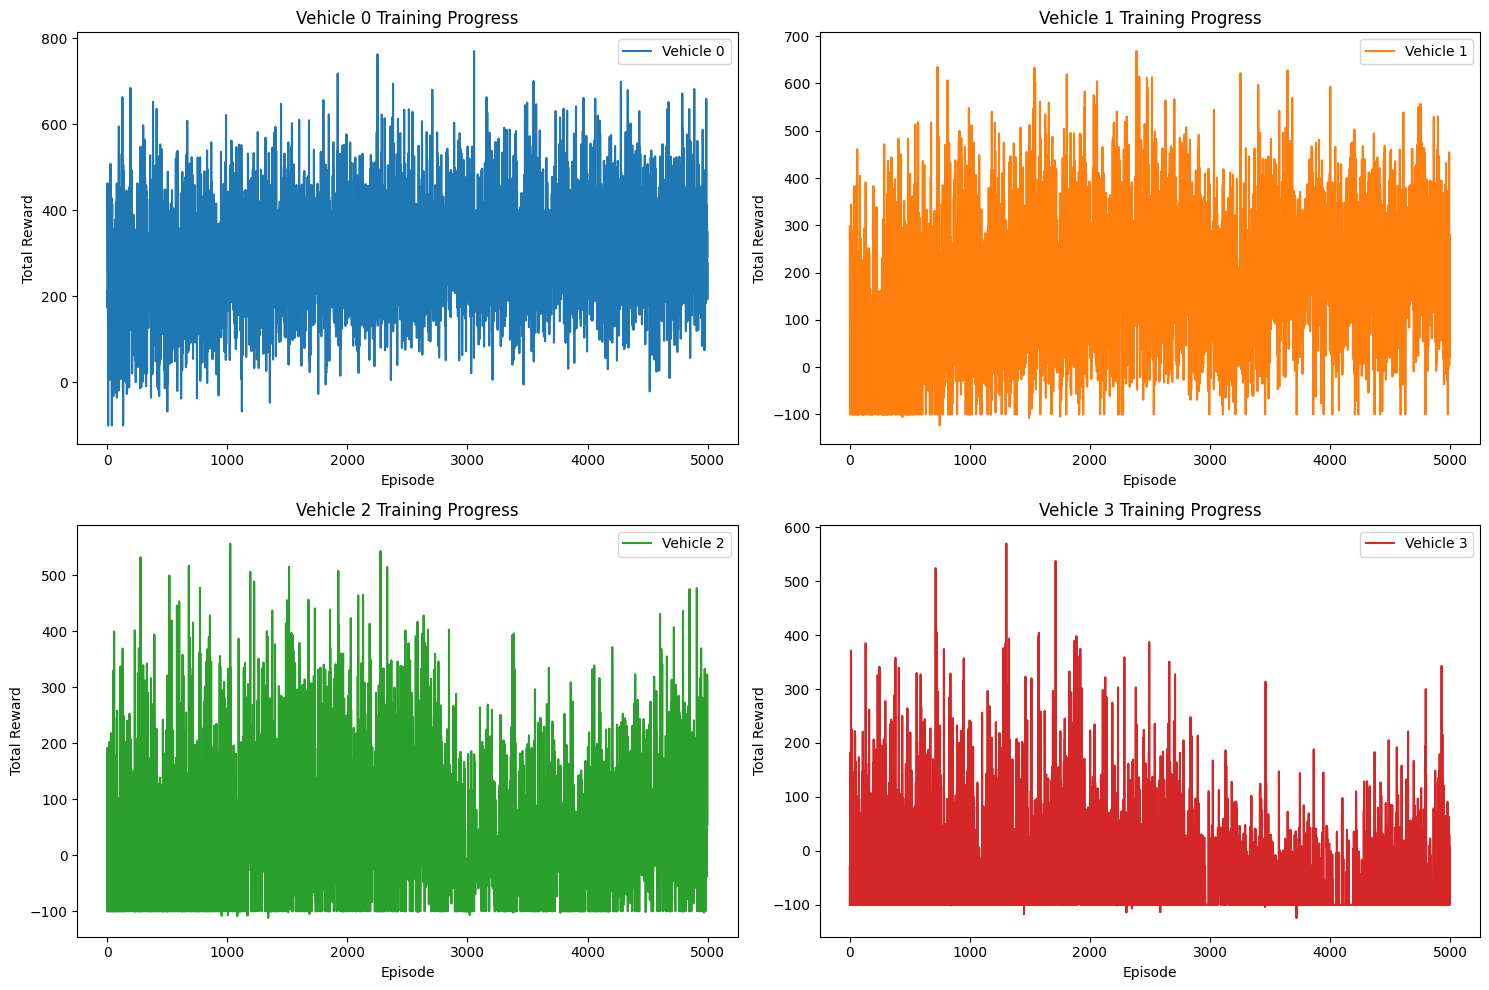

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axs = axs.flatten()

for i in range(len(scores)):
    axs[i].plot(scores[i], label=f'Vehicle {i}', color=f'C{i}')

    axs[i].set_title(f"Vehicle {i} Training Progress")
    axs[i].set_xlabel("Episode")
    axs[i].set_ylabel("Total Reward")
    axs[i].legend()

plt.tight_layout()
plt.show()

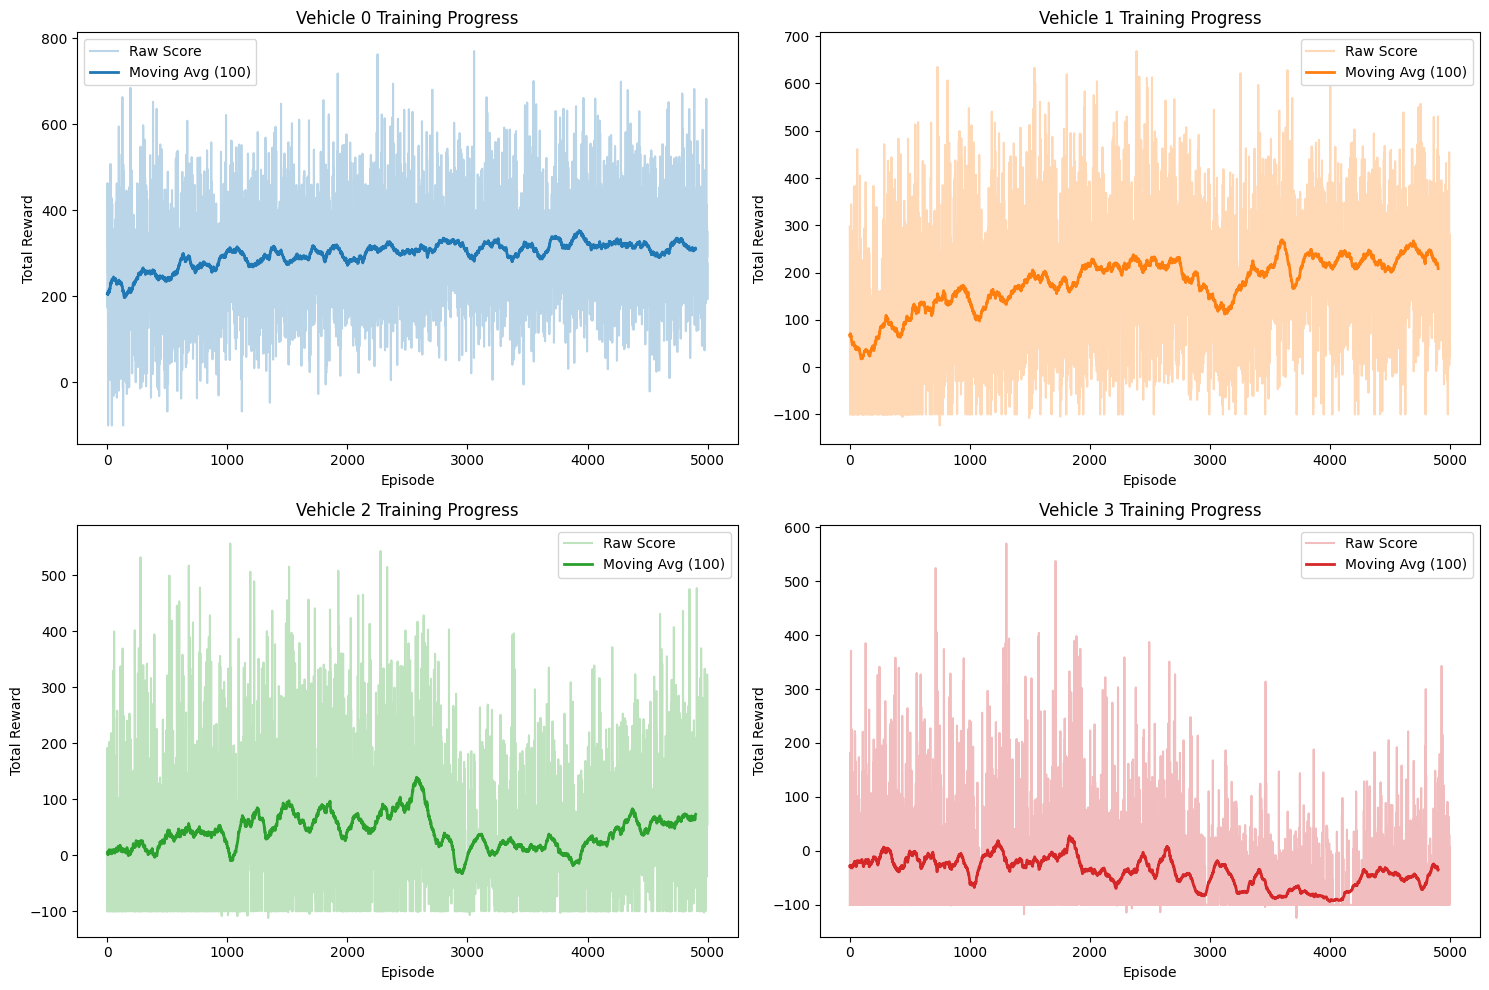

In [12]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axs = axs.flatten()

for i in range(len(scores)):
    axs[i].plot(scores[i], label='Raw Score', color=f'C{i}', alpha=0.3)

    if len(scores[i]) > 100:
        smooth_scores = moving_average(scores[i])
        axs[i].plot(smooth_scores, label='Moving Avg (100)', color=f'C{i}', linewidth=2)

    axs[i].set_title(f"Vehicle {i} Training Progress")
    axs[i].set_xlabel("Episode")
    axs[i].set_ylabel("Total Reward")
    axs[i].legend()

plt.tight_layout()
plt.show()